# Complete analysis with Skan

In this notebook, we reproduce the analysis leading to Figure 2 of our paper, submitted to PeerJ.

## 0. Getting the data

First, we need to download the input data, which is posted at the Open Science Framework (OSF) as a zip file. Many thanks to the OSF for providing hosting for scientific data. The data be downloaded at this URL:

    https://osf.io/7vyx3
    
Download and extract the zipfile, and make sure the `schizonts` folder contained within it is placed in this notebook's working directory.

## 1. Using `skan.pipe` to get a branch dataset for analysis

In [1]:
from glob import glob


schizont_files = glob('schizonts/*.tif')
# remove files ending with '01.tif', which are low-res overview images
schizont_files = list(filter(lambda x: not x.endswith('01.tif'),
                             schizont_files))

Now we process all 96 images. This should take about a minute on a modern laptop, but could be faster on a multicore machine, as it processes images using as many CPUs as are avaliable.

In [2]:
from skan import pipe
import toolz as tz


data, per_image_data = tz.last(pipe.process_images(
    schizont_files,
    image_format='fei',
    threshold_radius=5e-8,
    smooth_radius=0.1,
    brightness_offset=0.075,
    scale_metadata_path='Scan/PixelHeight',
    crop_radius=20,
    smooth_method='Gaussian'
))

96it [00:29,  8.33it/s]


Next, we use the filename to infer the infection status of each image.

In [3]:
def infection_status(filename):
    if 'Uninf' in filename:
        return 'normal'
    else:
        return 'infected'


data['infection'] = data['filename'].apply(infection_status)

Also encoded in the filename are the *cell number* (unique by infection status) and the *field number* (each cell membrane is imaged at several non-overlapping locations).

In [4]:
import re  # regular expressions, for text matching


def cell_number(filename):
    regex = r'.*RBC(\d+)_\d\d.tif'
    regex = re.compile(regex)
    match = regex.match(filename)
    if match is not None:
        return int(match.group(1))
    else:
        return None
    
def field_number(filename):
    regex = r'.*RBC\d+_(\d\d).tif'
    regex = re.compile(regex)
    match = regex.match(filename)
    if match is not None:
        return int(match.group(1))
    else:
        return None
    
data['cell number'] = data['filename'].apply(cell_number)
data['field number'] = data['filename'].apply(field_number)

## 2. Cleaning up the data

Next, we filter the branches by using the [*shape index*](http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.shape_index). We have used a very simple method to extract skeletons (see [Getting started](getting_started.html)), which does an acceptable job but creates a lot of false branches. Since the goal of Skan is to analyse skeletons, rather than generate them, we attempt to filter the branches, and measure only those that look like ridges according to the shape index.

In [5]:
ridges = ((data['mean shape index'] < 0.625) &
          (data['mean shape index'] > 0.125))

For the same reason, we only look at junction-to-junction branches, which are more accurately identified by our method than junction-to-endpoint branches.

In [6]:
j2j = data['branch-type'] == 2
datar = data.loc[ridges & j2j].copy()

Finally, we make a new column of measurements in a more natural scale for our purpose.

In [7]:
datar['branch distance (nm)'] = datar['branch-distance'] * 1e9

## 3. Making the figure

In [8]:
import numpy as np
import imageio as iio
from skimage import morphology
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from skan.pre import threshold

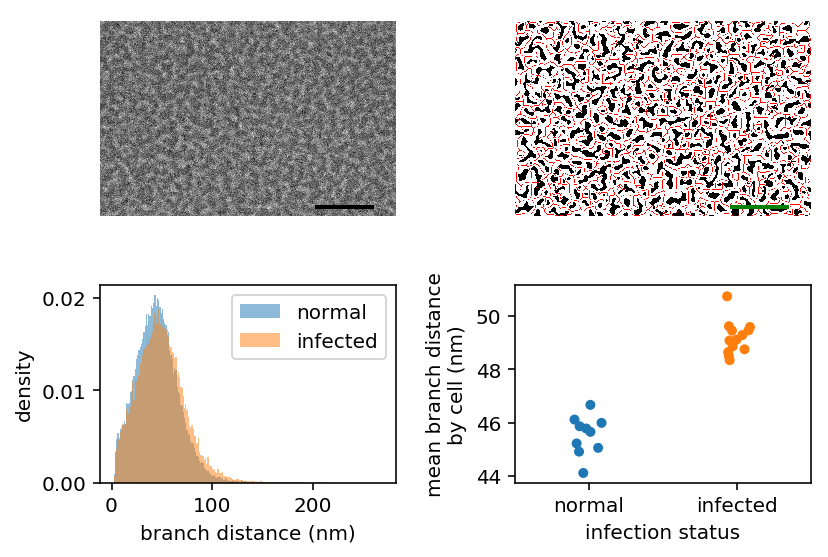

In [9]:
fig, axes = plt.subplots(2, 2)
ax = axes.ravel()

# PANEL A
# display an arbitrary image
crop = (slice(20, -20),) * 2
image_raw = iio.imread('schizonts/schizont4_UninfRBC7_06.tif',
                       format='fei')
image = image_raw[crop]
ax[0].imshow(image, cmap='gray')
ax[0].set_axis_off()

# add a 300nm scale bar
height, width = image.shape
scalenm = image.meta['Scan']['PixelHeight'] * 10**9
ax[0].plot((1096, 1096 + 300 / scalenm), (940, 940),
           c='k', lw=2);

# PANEL B
# Next, show the smoothed binary image and corresponding skeleton
radius = int(np.ceil(50/scalenm))
sigma = radius * 0.1
thresholded = threshold(image, sigma=sigma,
                        radius=radius, offset=0.075,
                        smooth_method='gaussian')
viz = np.zeros(image.shape + (3,), dtype=float)
viz[thresholded] = [1, 1, 1]
skeleton = morphology.skeletonize(thresholded)
fat_skeleton = morphology.binary_dilation(skeleton)
viz[fat_skeleton] = [1, 0, 0]
ax[1].imshow(viz)
ax[1].set_axis_off()
ax[1].plot((1096, 1096 + 300 / scalenm), (940, 940),
           c='g', lw=2)

# PANEL C
# Add a panel with a histogram of all branch lengths by infection status
_, bins = np.histogram(datar['branch distance (nm)'], bins='auto')
for inf, df in (datar.sort_values(by='infection', ascending=False)
                .groupby('infection', sort=False)):
    ax[2].hist(df['branch distance (nm)'], bins=bins,
               density=True, alpha=0.5, label=inf)

ax[2].legend()
ax[2].set_xlabel('branch distance (nm)')
ax[2].set_ylabel('density')

# PANEL D
# Finally, a panel grouping the data by cell, showing the difference
# between infected and uninfected cells
cellmeans = (datar.groupby(['infection', 'cell number'])
                  .mean().reset_index())
sns.stripplot(x='infection', y='branch distance (nm)', data=cellmeans,
              jitter=True, order=('normal', 'infected'), ax=ax[3])
              
ax[3].set_xlabel('infection status')
ax[3].set_ylabel('mean branch distance by cell (nm)')
ax[3].set_ylabel('mean branch distance\nby cell (nm)')

# Use matplotlib's automatic layout algorithm
fig.tight_layout()